In [1]:
# -*- coding: utf-8 -*-
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy.optimize import minimize
from datetime import datetime
from scipy.special import logsumexp

In [2]:
seed_value = 0
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
class Obstacle:
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        self.obstacle_positions = np.array(obstacle_positions)
        self.obstacle_radius = np.array(obstacle_radius)
        self.obs_cost = obs_cost
        self.boundary_x = boundary_x
        self.boundary_y = boundary_y

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            cost += float(x_curr[0] > op[0] and x_curr[0] < op[0] + self.obstacle_radius[obs_i] and
                          x_curr[1] > op[1] and x_curr[1] < op[1] + self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def compute_boundary_penalty(self, x_curr):
        return float(x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or
                     x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]) * self.obs_cost

    def check_hit_obstacle(self, x_curr):
        for pos, r in zip(self.obstacle_positions, self.obstacle_radius):
            if (x_curr[0] > pos[0] and x_curr[0] < pos[0] + r and x_curr[1] > pos[1] and x_curr[1] < pos[1] + r):
                return True
        return False

    def check_hit_boundary(self, x_curr):
        return x_curr[0] < self.boundary_x[0] or x_curr[0] > self.boundary_x[1] or x_curr[1] < self.boundary_y[0] or x_curr[1] > self.boundary_y[1]

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Rectangle(obs_pos, obs_r, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class CircleObstacle(Obstacle):
    def __init__(self, obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost):
        super().__init__(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            op = self.obstacle_positions[obs_i]
            distance_to_center = np.sqrt((x_curr[0] - op[0])**2 + (x_curr[1] - op[1])**2)
            cost += float(distance_to_center <= self.obstacle_radius[obs_i]) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos, obs_r in zip(self.obstacle_positions, self.obstacle_radius):
            obs = plt.Circle(obs_pos, obs_r, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class PolygonObstacle(Obstacle):
    def __init__(self, obstacle_positions, boundary_x, boundary_y, obs_cost):
        # Here, obstacle_positions should be a list of vertices for each polygon
        super().__init__(obstacle_positions, None, boundary_x, boundary_y, obs_cost)

    def compute_obstacle_cost(self, x_curr):
        num_obs = len(self.obstacle_positions)
        cost = 0
        for obs_i in range(num_obs):
            polygon = Polygon(self.obstacle_positions[obs_i])
            cost += float(polygon.contains_point(x_curr)) * self.obs_cost
        return cost

    def plot_obstacles(self, ax):
        for obs_pos in self.obstacle_positions:
            obs = Polygon(obs_pos, color='k', fill=True, zorder=6)
            ax.add_patch(obs)

class Map:
    def __init__(self, obstacles):
        self.obstacles = obstacles

    def compute_total_obstacle_cost(self, x_curr):
        total_cost = 0
        for obstacle in self.obstacles:
            total_cost += obstacle.compute_obstacle_cost(x_curr)
        return total_cost

    def compute_total_boundary_penalty(self, x_curr):
        total_penalty = 0
        for obstacle in self.obstacles:
            total_penalty += obstacle.compute_boundary_penalty(x_curr)
        return total_penalty

    def check_hit_any_obstacle(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_obstacle(x_curr):
                return True
        return False

    def check_hit_any_boundary(self, x_curr):
        for obstacle in self.obstacles:
            if obstacle.check_hit_boundary(x_curr):
                return True
        return False

    def plot_map(self, ax):
        for obstacle in self.obstacles:
            obstacle.plot_obstacles(ax)


In [4]:
class Dynamics_Linearized:
    def __init__(self, F, G, S):
        self.F = F
        self.G = G
        self.S = S

    def compute_next_state(self, state, control, noise):
        return self.F @ state + self.G @ control + self.S @ noise
    
class Dynamics_Nonlinear:
    def __init__(self, dt):
        self.dt = dt

    def compute_next_state(self, state, control, noise):
        next_state = np.zeros_like(state)
        next_state[0] = state[0] + self.dt * (control[0] + noise[0]) * np.cos(state[2])
        next_state[1] = state[1] + self.dt * (control[0] + noise[0]) * np.sin(state[2])
        next_state[2] = state[2] + self.dt * (control[1] + noise[1])
        return next_state


In [5]:
class PathIntegral:
    def __init__(self, dynamics, obstacle, true_mu, Sigma, x_init, x_goal, dist_weight, T, dt, num_trajs, max_steps, num_simulation, gammas, method):
        self.dynamics = dynamics
        self.obstacle = obstacle
        self.true_mu = true_mu
        self.Sigma = Sigma
        self.x_init = x_init
        self.x_goal = x_goal
        self.state_dim = len(x_init)
        self.control_dim = len(true_mu)

        self.dist_weight = dist_weight
        self.T = T
        self.dt = dt
        self.num_trajs = num_trajs
        self.max_steps = max_steps
        self.num_simulation = num_simulation
        self.gammas = gammas
        self.method = method

        self.time_steps = int(self.T/self.dt)
        self.goal_tolerance = 0.1
    
        self.success_time = []
        self.success_index = []
        self.fail_index = []

        self.x_hists = np.zeros((num_simulation, max_steps+1, 2))*np.nan

    def path_integral(self):
        noise_samples = self.sample_noise()
        costs, x_vis = self.rollout(noise_samples)

        if self.method == 'DR Non':
            u_curr = self.update_useq_risk_neutral(costs, noise_samples, lambda_neut=100)
        elif self.method == 'DR NM':
            u_curr = self.update_control_sequence_NM(costs, noise_samples)
        else:
            raise ValueError(f"Unknown method: {self.method}")
            
        return u_curr, x_vis

    def estimate_mu(self):
        return np.mean(np.random.multivariate_normal(self.true_mu, self.Sigma, self.time_steps), axis=0)

    def sample_noise(self) :
        return np.random.multivariate_normal(self.estimate_mu(), self.Sigma , [self.num_trajs, self.time_steps])

    def rollout(self, noise_samples):
        costs = np.zeros(self.num_trajs)
        x_vis = np.zeros((20, self.time_steps, 2)) * np.nan
        
        for k in range(self.num_trajs):
            
            goal_reached = False
            dist_to_goal = 1e9
            x_curr = self.x_init.copy()
                
            for t in range(self.time_steps):
            
                x_curr = self.dynamics.compute_next_state(x_curr, np.zeros(self.control_dim), noise_samples[k, t, :])

                dist_to_goal = np.linalg.norm(x_curr[:2] - self.x_goal[:2])
    
                costs[k] += self.dist_weight * dist_to_goal # stage cost
                costs[k] += self.obstacle.compute_obstacle_cost(x_curr) # obstacle cost
                costs[k] += self.obstacle.compute_boundary_penalty(x_curr) # boundary penalty
                
                if dist_to_goal <= self.goal_tolerance:
                    goal_reached = True

                if goal_reached or t == self.time_steps:
                    costs[k] += (1 - float(goal_reached)) * dist_to_goal * 1e3 # terminal cost
        return costs, x_vis


    def update_useq_risk_neutral(self, costs, noise_samples,lambda_neut=100) :
        costs = np.exp(- costs / lambda_neut) 
        sum_costs = np.sum(costs)    

        u_curr = np.zeros((self.time_steps, self.control_dim))
        for t in range(self.time_steps) :
            for k in range(len(costs)) :
                u_curr[t,:] += (costs[k] / sum_costs ) * noise_samples[k,t,:] 
        return u_curr

    
    def update_control_sequence_NM(self, costs, noise_samples):

        def opt_cost_func(lambda_, gamma, costs, num_trajs):
            log_denominator = logsumexp(- costs / lambda_) - np.log(num_trajs)
            denominator = np.exp(log_denominator)
            if denominator == 0:
                return np.inf  # Return a large value to indicate failure
            return gamma / lambda_ - lambda_ * np.log(denominator)

        min_lambda_r = np.inf
        for gamma in self.gammas:
            # Mutiple methods
            result = minimize(opt_cost_func, x0=100.0, args=(gamma, costs, self.num_trajs), method='Powell', options={'maxiter': 10000})

            if result.success and result.x[0] < min_lambda_r:
                min_lambda_r = result.x[0]
                
            elif not result.success:
                print("Optimization failed for gamma =", gamma)

        costs = np.exp(-costs / min_lambda_r)
        sum_costs = np.sum(costs)

        u_curr = np.zeros((self.time_steps, self.control_dim))
        u_curr[0, :] = np.sum((costs / sum_costs)[:, None] * noise_samples[:, 0, :], axis=0)

        return u_curr
    


    def simulation(self):
        for k in range(self.num_simulation):
            terminate = False
            hit_obstacle = False
            hit_boundary = False

            u_curr = np.zeros((self.time_steps, 2))
            x_hist = np.zeros((self.max_steps+1, 4)) * np.nan
            u_hist = np.zeros((self.max_steps+1, 2)) * np.nan
            x_hist[0] = self.x_init.copy()

            for t in range(self.max_steps):

                u_curr, x_vis = self.path_integral() 
                u_hist[t] = u_curr[0]

                noise = self.true_mu + np.random.multivariate_normal(np.zeros(self.control_dim), self.Sigma) # drift term + increment of a standard Wiener process
                
                x_hist[t+1] = self.dynamics.compute_next_state(x_hist[t], u_curr[0], noise)

                hit_obstacle = self.obstacle.check_hit_obstacle(x_hist[t+1])
                if hit_obstacle:
                    terminate = True
                    self.fail_index.append(k)
                    print("Hit obstacle")
                    break
                
                hit_boundary = self.obstacle.check_hit_boundary(x_hist[t+1])
                if hit_boundary:
                    terminate = True
                    self.fail_index.append(k)
                    print("Hit boundary")
                    break
                
                # Goal check
                if np.linalg.norm(x_hist[t+1, :2] - self.x_goal) <= self.goal_tolerance:
                    print(f"Goal reached at t={t * self.dt}s")
                    self.success_time.append(t * self.dt)
                    terminate = True
                    self.success_index.append(k)
                    break
            
            self.x_hists[k, :t, :] = x_hist[:t, :2]

            if terminate:
                self.simulation_plot(x_hist)
        
        self.final_result()

    def simulation_plot(self, x_hist):
        fig, ax = plt.subplots()
        ax.plot([self.x_init[0]], [self.x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([self.x_goal[0]], [self.x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        self.obstacle.plot_obstacles(ax)
        ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
        ax.set_xlim(self.obstacle.boundary_x)
        ax.set_ylim(self.obstacle.boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()
            
    def final_result(self):
        fig, ax = plt.subplots()
        ax.plot([self.x_init[0]], [self.x_init[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
        ax.plot([self.x_goal[0]], [self.x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)
        self.obstacle.plot_obstacles(ax)

        ax.set_xlim(self.obstacle.boundary_x)
        ax.set_ylim(self.obstacle.boundary_y)
        ax.set_xlabel(r'$p_{x}$')
        ax.set_ylabel(r'$p_{y}$')
        plt.gcf().set_dpi(600)
        ax.set_aspect('equal')
        plt.tight_layout()

        ax.plot(self.x_hists[self.success_index,:,0].T, self.x_hists[self.success_index,:,1].T, 'b', linewidth=0.8)
        ax.plot(self.x_hists[self.fail_index,:,0].T, self.x_hists[self.fail_index,:,1].T, 'r', linewidth=0.8)
        ax.set_title(f'Trajectories using {self.method} method')

        # Save the plot with the current time as the filename
        filename = os.path.join("./log", f"plot_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        fig.savefig(filename)

        plt.show()

In [6]:
'''
    def update_control_sequence_NM(self, costs, noise_samples):

        def opt_cost_func(lambda_, gamma, costs, num_trajs):
            log_denominator = logsumexp(- costs / lambda_) - np.log(num_trajs)
            denominator = np.exp(log_denominator)
            if denominator == 0:
                return np.inf  # Return a large value to indicate failure
            return gamma / lambda_ - lambda_ * np.log(denominator)

        min_lambda_r = np.inf
        min_cost = np.inf

        for gamma in self.gammas:
            result = minimize(opt_cost_func, x0=100.0, args=(gamma, costs, self.num_trajs), method='Powell', options={'maxiter': 10000})

            if result.success and result.fun < min_cost:
                min_lambda_r = result.x[0]
                min_cost = result.fun
                    
            elif not result.success:
                print("Optimization failed for gamma =", gamma)

        weights = np.exp(-costs / min_lambda_r) / np.exp(min_cost)
        weights /= np.sum(weights)

        u_curr = np.zeros((self.time_steps, self.control_dim))

        #for t in range(self.time_steps):
        #    u_curr[t, :] = np.sum(weights[:, None] * noise_samples[:, t, :], axis=0)
        u_curr[0, :] = np.sum(weights[:, None] * noise_samples[:, 0, :], axis=0)
        return u_curr
'''

'\n    def update_control_sequence_NM(self, costs, noise_samples):\n\n        def opt_cost_func(lambda_, gamma, costs, num_trajs):\n            log_denominator = logsumexp(- costs / lambda_) - np.log(num_trajs)\n            denominator = np.exp(log_denominator)\n            if denominator == 0:\n                return np.inf  # Return a large value to indicate failure\n            return gamma / lambda_ - lambda_ * np.log(denominator)\n\n        min_lambda_r = np.inf\n        min_cost = np.inf\n\n        for gamma in self.gammas:\n            result = minimize(opt_cost_func, x0=100.0, args=(gamma, costs, self.num_trajs), method=\'Powell\', options={\'maxiter\': 10000})\n\n            if result.success and result.fun < min_cost:\n                min_lambda_r = result.x[0]\n                min_cost = result.fun\n                    \n            elif not result.success:\n                print("Optimization failed for gamma =", gamma)\n\n        weights = np.exp(-costs / min_lambda_r) / n

In [7]:
method = 'DR Non' # method = 'DR Non', 'DR bisection', 'DR grid_search', 'DR NM'
T = 10.0
dt = 0.1

In [8]:
obstacle_positions = np.array([[-3.5, 0.0], [-2.5, 2.0]])
obstacle_radius = np.array([1.0/2, 1.0/2])

boundary_x = [-4.0, 1.0]
boundary_y = [-1.0, 4.0]

obs_cost = 1e3

obstacle = CircleObstacle(obstacle_positions, obstacle_radius, boundary_x, boundary_y, obs_cost)

In [9]:
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
        
G= np.array([[(dt**2)/2, 0],
             [0, (dt**2)/2],
             [dt, 0],
             [0, dt]])

# dynamics = Dynamics_Linearized(F, G, G)
dynamics = Dynamics_Nonlinear(dt)

In [10]:
num_simulation = 10
max_steps = 600
num_trajs = 30

true_mu = np.array([0.03, 0.03])
Sigma = np.array([[0.01, 0.0], 
                  [0.0, 0.01]])

dist_weight = 0.01

gamma = range(0, 300, 3)

goal_tolerance = 0.1

x_init = np.array([-3.0, 3.0, 0, 0])
x_goal = np.array([0,0])

path_integral = PathIntegral(dynamics, obstacle, true_mu, Sigma, x_init, x_goal, dist_weight, T, dt, num_trajs, max_steps, num_simulation, gamma, method)

Hit boundary


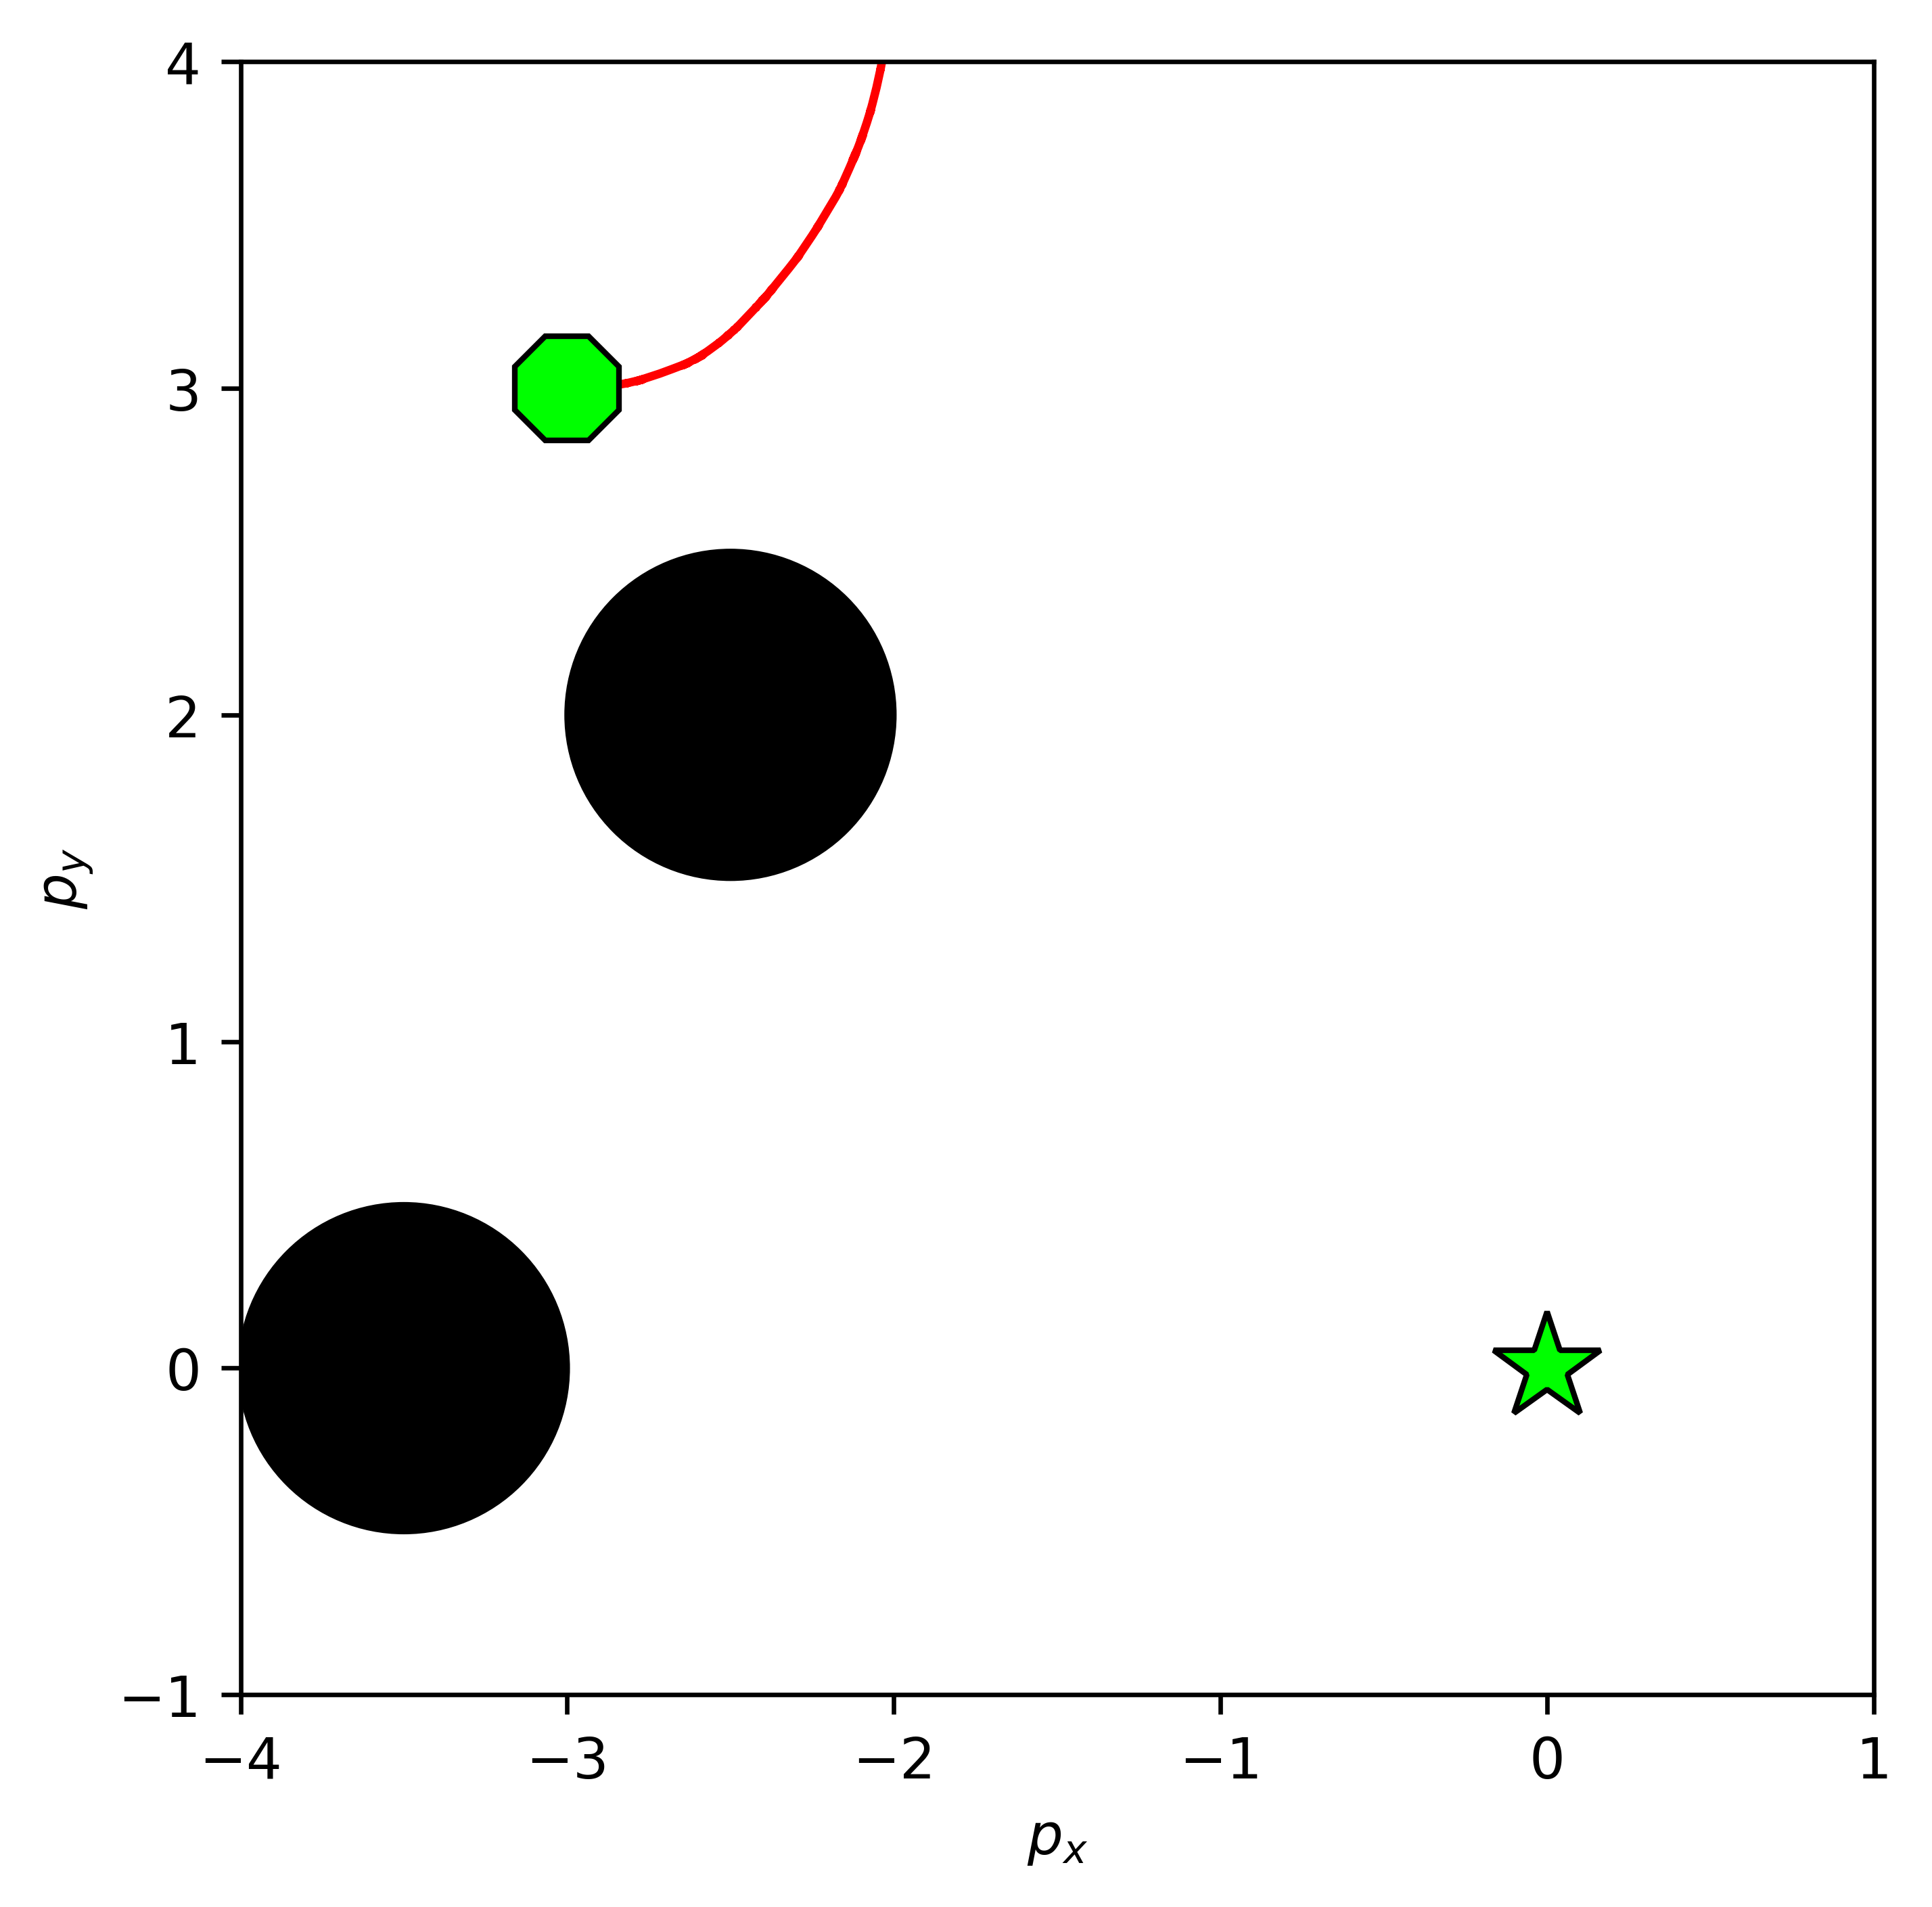

KeyboardInterrupt: 

In [11]:
path_integral.simulation()

$$\begin{align*}
E[X] &= E[E[X | Y]] \\
&= \int_0^1 \frac{y}{2} \,dy \\
&= \frac{1}{2} \int_0^1 y \,dy \\
&= \frac{1}{2} \cdot \frac{1}{2} \cdot 1 \\
&= \frac{1}{4}.
\end{align*}$$

Next, let's find the conditional variance of \(X\) given \(Y = y\):

$$\begin{align*}
\text{Var}[X | Y = y] &= E[X^2 | Y = y] - (E[X | Y = y])^2 \\
&= \int_0^y x^2 \cdot \frac{1}{y} \,dx - \left(\frac{y}{2}\right)^2 \\
&= \frac{y^2}{3} - \frac{y^2}{4} \\
&= \frac{y^2}{12}.
\end{align*}$$

Now, we can find the marginal variance of \(X\):

$$\begin{align*}
\text{Var}[X] &= E[\text{Var}[X | Y]] + \text{Var}[E[X | Y]] \\
&= E\left[\frac{Y^2}{12}\right] + \text{Var}\left[\frac{Y}{2}\right] \\
&= \frac{1}{12} E[Y^2] + \frac{1}{4} \text{Var}[Y] \\
&= \frac{1}{12} \int_0^1 y^2 \,dy + \frac{1}{4} \cdot \frac{1}{12} \cdot 1 \quad \text{(since Y is uniformly distributed on (0,1))} \\
&= \frac{1}{12} \cdot \frac{1}{3} \cdot 1 + \frac{1}{48} \\
&= \frac{1}{36} + \frac{1}{48} \\
&= \frac{1}{12} \cdot \frac{1}{3} + \frac{1}{12} \cdot \frac{1}{4} \\
&= \frac{1}{12} \left(\frac{1}{3} + \frac{1}{4}\right) \\
&= \frac{1}{12} \cdot \frac{7}{12} \\
&= \frac{7}{144}.
\end{align*}$$

